In [2]:
import random
from collections import Counter
import numpy as np
import pandas as pd
from sklearn import metrics
import matplotlib.pyplot as plt

# Data and Tags

For a training set, 12 sentences with roughly 250 POS tagged words were extracted from the Brown Corpus (using nltk). To imitate field data, about 1/4 of th training tokens were given random POS tags. Ten more sentences were randomly chosen as test data. These have the correct POS tags.
An additional 275 sentences with approximately 6000 words simulates data that has not been annotated yet. 

The three data sets are stored in to files for printing and sharing.

See table below for POS tags used in this data.

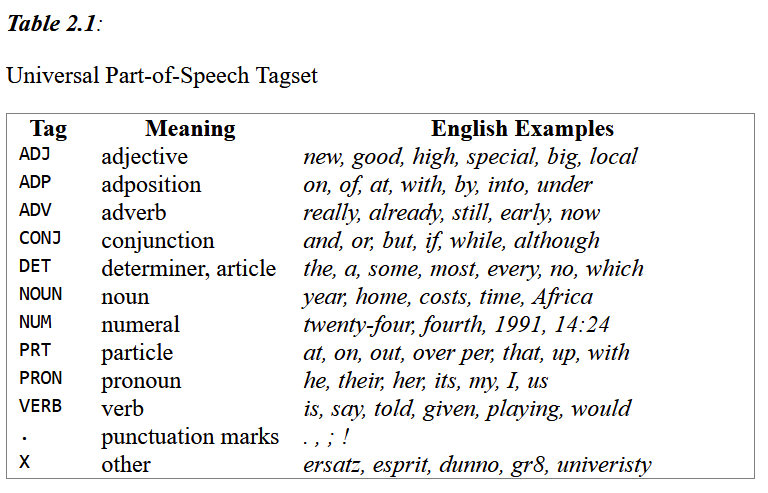

# Working with Data Files

Data should be stored in data files. Once participants have made changes to the data file, it can be extracted from the file and formatted for retraining. 

In [3]:
def writeDataFiles(tuple_dataset, filename, tagged=True):
    '''write data sets to files for printing and sharing
    Do not include if data is supposed to be unannotated/tagged'''
    
    datastring = []
    for sent in tuple_dataset:
        sentence = []
        for pair in sent:
            if tagged:
                sentence.append(pair[0] + '/' + pair[1])
            else: 
                sentence.append(pair[0])
        datastring.append(' '.join(sentence))

    with open(filename, 'w') as T:
        T.write('\n'.join(datastring))

In [4]:
def extractData(filename, tagged=True):
    '''Get data from files and format for training & testing and predictions'''
    
    with open(filename) as file:
        sentencestrings = [line.strip() for line in file]
    
    formatted_data = []
    for sent in sentencestrings:
        sentence = []
        for element in sent.split():
            if tagged:
                pair = element.split('/')
                sentence.append((pair[0], pair[1]))
            else: 
                sentence.append((element, 'X'))
        formatted_data.append(sentence)

    return formatted_data

## To  write files
`dataFiles(random_train_set, 'pos.train')`
`dataFiles(test_set, 'pos.test')`
`dataFiles(untagged_set, 'pos.unann', tagged=False)`

## To Read Files

In [5]:
train_set = extractData('pos.train')
test_set = extractData('pos.test')
untagged_set = extractData('pos.unann', tagged=False)

# Data Statistics

Use this code to write a file that tracks the iterations of training and the data statistics for each iteration. This can be used to see the effect of data size and data quality. 

**Document changes made since the last iteration that may not be tracked with this code (e.g. 30 tags were corrected in the training data)**

In [6]:
# statistics 
untagged_tokens = len([pair for sent in untagged_set for pair in sent])

train_tokens = [word for sent in train_set for word,tag in sent]

taglist = [tag for sent in train_set for word,tag in sent]
tag_distro = Counter(taglist) # frequency of tags in train data
tagset = list(set(taglist)) # unique tags

In [7]:
# Adjust this filename, with iteration number starting with 0 for original training
logfile = 'POS_TeamA_0.log'

# Document notes and other changes here
notes = "This is the original training.\n\n"

logstring = notes + "Train set has {} tokens.\nUnannotated tokens: {}.\n\nPOS tags in train set:\n\n".format(len(train_tokens),untagged_tokens)
for tag,freq in tag_distro.items():
    logstring+=tag + '   \t' + str(freq) + '\n'

with open(logfile, 'w') as logf:
    logf.write(logstring)

# Train POS tagger

We will run a simple Hidden Markov Model (HMM). Code adapted from https://www.mygreatlearning.com/blog/pos-tagging/#sh5. 

HMM is a probablistic (stochastic) approach. It will calculate the probability associated with a particular sequence of POST tags. It does this by computing both a Transition probability and Emission probability. 

## Compute Transition Probabilities

The transition probability is the likelihood that a sequence of three words in this language will contain, for example, a noun followed by a verb and a verb followed by another noun. The Transition probability should be high for a particular sequence to be predicted.

In [8]:
def t2_given_t1(t2, t1, tags=taglist):
    '''Frequency of t1 tag followed t2 tag in training data. 
    These counts will be used to calculate p(t2|t1):
    probability of t1 transitioning to t2'''
    
    #tags = [pair[1] for pair in train_bag]
    # how many times first tag occurs
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    # how many times t1 is followed by t2
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    
    return (count_t2_t1, count_t1)

Now we will create a table with the transition probability between each tag. Each cell gives you the probability to go from one part of speech to another. 

We calculate this with smoothing that allows us to still calculate a probability of transitions that do not occur in training data. The smoothing was done as follows:

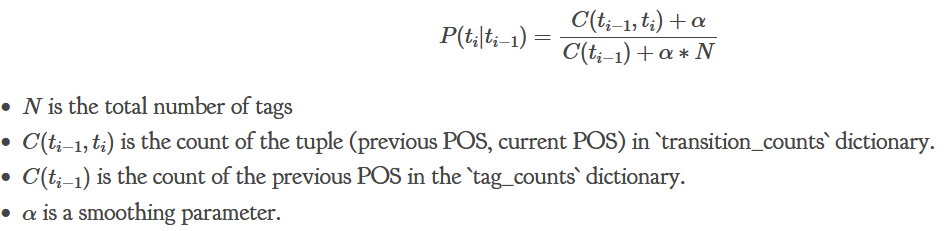

In [9]:
# smoothing value
ALPHA = 0.001

In [10]:
def transition_matrix_smooth(unique_tags, all_tags):
    
    tags_matrix = np.zeros((len(unique_tags), len(unique_tags)), dtype='float32')
    for i, t1 in enumerate(list(unique_tags)):
        for j, t2 in enumerate(list(unique_tags)): 
            tags_matrix[i, j] = (t2_given_t1(t2, t1)[0]+ALPHA)/(t2_given_t1(t2, t1)[1]+ALPHA*len(all_tags))

    return tags_matrix

def transition_matrix(unique_tags, all_tags):
    # smoothing value
    alpha = 0.00001
    
    tags_matrix = np.zeros((len(unique_tags), len(unique_tags)), dtype='float32')
    for i, t1 in enumerate(list(unique_tags)):
        for j, t2 in enumerate(list(unique_tags)): 
            if t2_given_t1(t2, t1)[1] == 0:
                tags_matrix[i, j] = (t2_given_t1(t2, t1)[0])/(t2_given_t1(t2, t1)[1])

    return tags_matrix

In [11]:
t_matrix = transition_matrix_smooth(tagset, taglist)

In [12]:
# convert the transition matrix to a df for better readability
trans_df = pd.DataFrame(t_matrix, columns = list(tagset), index=list(tagset))
display(trans_df)

,NOUN,PRT,ADV,.,VERB,CONJ,ADJ,ADP,PRON,DET,NUM
NOUN,0.182598,0.033213,0.033213,0.215795,0.166000,0.049812,0.033213,0.215795,0.016615,0.016615,0.033213
PRT,0.195277,0.000098,0.000098,0.195277,0.488045,0.000098,0.000098,0.000098,0.097687,0.000098,0.000098
ADV,0.302031,0.000075,0.075564,0.151053,0.151053,0.075564,0.000075,0.000075,0.075564,0.151053,0.000075
.,0.102609,0.034226,0.034226,0.205183,0.034226,0.205183,0.000034,0.068417,0.068417,0.170992,0.034226
VERB,0.099216,0.099216,0.066155,0.132278,0.033094,0.033094,0.066155,0.198400,0.033094,0.198400,0.033094
CONJ,0.393586,0.065652,0.065652,0.065652,0.196826,0.000066,0.000066,0.000066,0.065652,0.065652,0.065652
ADJ,0.602894,0.000055,0.054858,0.000055,0.000055,0.109662,0.164465,0.054858,0.000055,0.000055,0.000055
ADP,0.220244,0.036738,0.073439,0.000037,0.073439,0.000037,0.073439,0.073439,0.000037,0.440452,0.000037
PRON,0.216394,0.000108,0.216394,0.000108,0.324538,0.000108,0.108251,0.000108,0.108251,0.000108,0.000108
DET,0.352066,0.032035,0.000032,0.000032,0.096041,0.064038,0.256057,0.032035,0.032035,0.128044,0.000032


## Compute Emission Probabilities

The emission probability is the likelihood that a word will be any particular POS. For example, how likely is the word "box" a noun, "will" is a verb, "spot" is a verb, and "Will" is a noun. These sets of probabilities are Emission probabilities and should be high for a tag to be predicted.

We also use smoothing to account for zero occurences

In [13]:
def word_given_tag(word, tag, train_bag=zip(train_tokens,taglist)):
    '''Emission probablity p(tag|word) is calculated from
    how often this word labeled with this tag'''

    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list) #number of times this tag occurs
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word] 
    # total number of times the word occurred with the tag
    count_w_given_tag = len(w_given_tag_list)
     
    return (count_w_given_tag, count_tag)

## Compute Most Likely POS Tags

Now we can compute the one most likely sequence of POS tags for any sentence. All possible sequences have to be calculated and compared using our transition and emission probability tables. That is a lot of calculations, especially for long sentences! We will make this more efficient with the Viterbi algorithm which essentially a table that tracks the most optimal POS tag sequence up to the current word.

In [15]:
def Viterbi(words):
    state = []
    T = tagset # unique tags
     
    for wordorder, word in enumerate(words):
        #initialise probability "column" for a given observation
        p = [] 
        for tag in T:
            if wordorder == 0: # first word in sentence
                transition_p = trans_df.loc['.', tag] # punctuation tag represents sent start
            else:
                transition_p = trans_df.loc[state[-1], tag] 
                 
            # compute emission probability with smoothing
            emission_p = (word_given_tag(words[wordorder],tag)[0]+ALPHA)/(word_given_tag(words[wordorder],tag)[1]+ALPHA*len(all_tags))
            # compute probability of emitting given tag weighted by the transition
            state_probability = emission_p * transition_p    
            p.append(state_probability)
             
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
        
        # calculate "confidence" of sentence tagging
        c = sum(state)/len(words)
    
    return list(zip(words, state)), c

# Generate Predictions

Now that we have tables of probabilities, we can use them to predict the most likely POS tags for any sentence. 

First, we will predict the tags for our test sentences. We can then compare the predictions to the correct tags. This gives an evaluation metric for our POS tagger.

Second, we will predict tags for our unannotated sentences. We will then write that auto-tagged data results to a file. The sentences will be sorted by increasing "confidence" of the POS tagger. That is, how high the probability score is.

In [73]:
# tagging the test sentences

def predict(dataset):
    output = []
    tags = [[pair[1] for sent in dataset for pair in sent]]
for sent in test_set:
    words = [pair[0] for pair in sent]
    tagged_seq,_ = Viterbi(words)
    test_output.extend([pair[1] for pair in tagged_seq])
    
report = metrics.classification_report(test_tags,test_output, zero_division=0)
print(report)
#print(Counter([tag for sent in test_set for word,tag in sent]))

              precision    recall  f1-score   support

           .       0.15      0.36      0.21        22
         ADJ       0.00      0.00      0.00         7
         ADP       0.00      0.00      0.00        21
         ADV       0.00      0.00      0.00         9
        CONJ       0.00      0.00      0.00         3
         DET       0.00      0.00      0.00        25
        NOUN       0.16      0.23      0.19        39
         NUM       0.00      0.00      0.00         3
        PRON       0.00      0.00      0.00         5
         PRT       0.00      0.00      0.00         7
        VERB       0.00      0.00      0.00        27

    accuracy                           0.10       168
   macro avg       0.03      0.05      0.04       168
weighted avg       0.06      0.10      0.07       168

Counter({'NOUN': 39, 'VERB': 27, 'DET': 25, '.': 22, 'ADP': 21, 'ADV': 9, 'PRT': 7, 'ADJ': 7, 'PRON': 5, 'CONJ': 3, 'NUM': 3})


## Testing

# Test 

Test against withheld sentences and provide metrics. The test is running on individual sentences rather than a whole corpus.

Let's take another look the results. This is a confusion matrix. errors that 

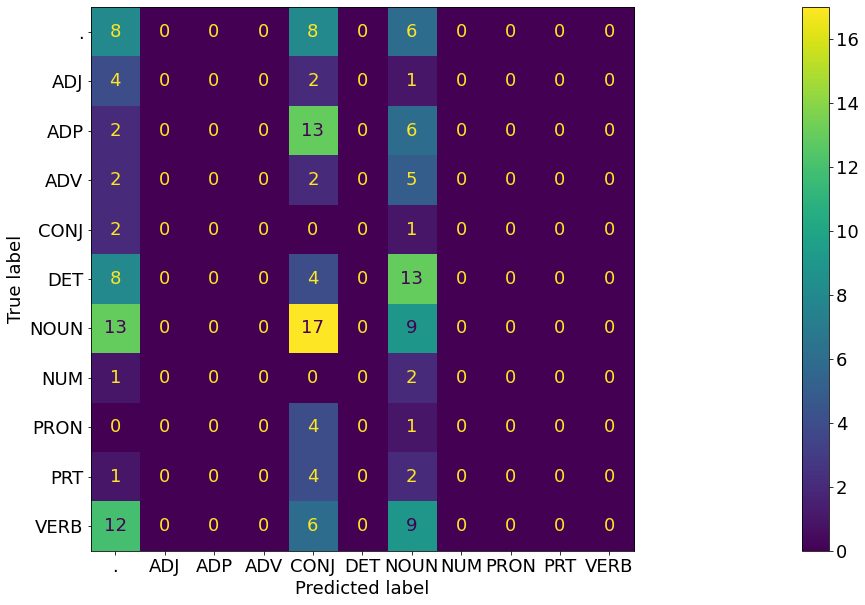

In [111]:
alpha_taglist = sorted(set(taglist))
cm = metrics.confusion_matrix(test_tags,test_output,labels=alpha_taglist)
disp = metrics.ConfusionMatrixDisplay(cm,display_labels=alpha_taglist)

plt.rcParams["figure.figsize"] = (60,10)
plt.rcParams.update({'font.size': 18})
disp.plot()
plt.show()

# Predict

Run POS tagger on unannotated sentences. Get predictions and sort the sentences based on "confidence" (higher maximum score on predicted sequence == higher confidence).

### categories for winning
- overall best (all and any metrics)
- best at most number of POS labels
- best with fewest iterations
- most improvement over fewest iterations